<a href="https://colab.research.google.com/github/GniwT/Udacity_Starbucks_Capstone_Project/blob/master/Starbucks_Data_ELT_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Udacity Starbucks Capstone Project**

Creator: Wing Tse

Date: July 8, 2020


### **Project Overview:**

This project is the Capstone project of the Machine Learning Nanodegree of Udacity. Starbucks sends out various promotional advertisements to the users of the Starbucks mobile app. The ad are either informational only, a discount or,BOGO (buy one get one free). The delivery schedule of the ad varied across different customers. This project is to analyse how effective the customers reacted to different promotional advertisements

The data is contained in three json files:



*   portfolio : offer ids and the meta data of each offer (such as delivery channels and rewards details etc.) 

*   profile: demographic data of the customers (such as age and income etc)
*   transcript: offers timeframes and the transactions details (such as amount of transactions etc.)



### **Problem Statement/ Metrics**

The goal of this project is to build a model that predicts whether the customer will make a purchase in response to different offers.

The starategy for solving this problem is as follows:


*   Exploring and visualizaing the data;
*   Data Preprocessing such as transforming or encoding;
*   Data analysis on the cleaned pre-processed data;
*   Feature engineering;
*   Randomized Hyperparameter tuning;
*   Build the models of logistic regression, random forest classifier, and XGBoost;
*   Evaluate the models through the accuracy and F1-score.


### **1. Data ETL Pipeline**
This section data ETL, which is to load, extract, and prepare the data. I will also use the functions saved in py. file for data cleaning.

In [ ]:
# For Google Colab use only. 
# This part can be omitted if running on local Jupter Notebook
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Udacity_Starbucks_CapstoneProject')  

#PyData Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# Importing the functions I built
from clean_portfolio_py import to_clean_portfolio  
from clean_profile_py import to_clean_profile  
from clean_transcript_py import to_clean_trascript
from build_main_df_py import to_build_main_df

#Magic Commands
%matplotlib inline

# Matplotlib style
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import the json file
portfolio = pd.read_json('/content/drive/My Drive/Colab Notebooks/Udacity_Starbucks_CapstoneProject/data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/content/drive/My Drive/Colab Notebooks/Udacity_Starbucks_CapstoneProject/data/profile.json', orient='records', lines=True)
transcript = pd.read_json('/content/drive/My Drive/Colab Notebooks/Udacity_Starbucks_CapstoneProject/data/transcript.json', orient='records', lines=True)

In [ ]:
# apply the function of clean_portfolio py.file
clean_portfolio = to_clean_portfolio(portfolio)

In [ ]:
# apply the function of clean_profile on our dataset 'profile' to  get a cleaned profile
clean_profile = to_clean_profile(profile)
clean_profile.sample(3)

,gender,customer_id,age_bin,income_bin,membership_since
1387,M,983220d3eb664ad5b2dcbe70c8428904,50s,30k,2014
10320,F,6879bd496adb4c2599146ddfba829d14,70s,100k,2017
13466,M,0552370c278345298835cc70e616c96c,40s,100k,2017


In [ ]:
# apply the function of clean_transcript on our dataset 'transcript' and 'profile to  get a cleaned profile
clean_transcript = to_clean_trascript(transcript, profile)
clean_transcript.sample(3)

,customer_id,event,time,offer_received,offer_viewed,transaction,offer_completed,amount,offer_id,offer_type
236022,f969f5f7c6964961ae6c27bd366d51b6,offer completed,546,0,0,0,1,0.00,0,0
220605,f021439f0396486b868d30ddaa6b272c,offer viewed,510,0,1,0,0,0.00,3f207df678b143eea3cee63160fa8bed,informational
164082,5bc9f27518b64163be2f236dcfcb9ce7,transaction,408,0,0,1,0,30.91,0,0


In [ ]:
# Create a list of offer event types
offer_event_ls = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = clean_transcript[clean_transcript['event'].isin(offer_event_ls)].index

# Find index where feature event is 'transaction'
trans_index = clean_transcript[~clean_transcript['event'].isin(offer_event_ls)].index

# Create offers_df
offers_df = clean_transcript.loc[offer_index,:]
offers_df = offers_df[['customer_id', 'offer_id', 'time', 'offer_received', 'offer_viewed', 'offer_completed']]

# Create transaction_df
trans_df = clean_transcript.loc[trans_index,:]
trans_df = trans_df[['customer_id', 'time', 'amount', 'offer_id']]

In [ ]:
# apply the function of to_build_main_df to combine the dataframes in one dataframe
main_df = to_build_main_df(clean_portfolio, clean_profile, offers_df, trans_df)

# reorder the columns of combined_data_df
main_df_col = ['customer_id', 'offer_id', 'time']
portfolio_ls = clean_portfolio.columns.tolist()
portfolio_ls.remove('offer_id')
profile_ls = clean_profile.columns.tolist()
profile_ls.remove('customer_id')
main_df_col.extend(portfolio_ls)
main_df_col.extend(profile_ls)
main_df_col.extend(['total_amount', 'cust_action'])
main_df = main_df.reindex(main_df_col, axis=1)

main_df.head(5)

,customer_id,offer_id,time,reward,difficulty,duration,offer_type,web,email,mobile,social,bogo,informational,discount,gender,age_bin,income_bin,membership_since,total_amount,cust_action
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,0,0,72,informational,0,1,1,1,0,1,0,M,30s,70k,2017,22.16,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,0,0,96,informational,1,1,1,0,0,1,0,M,30s,70k,2017,8.57,1
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,5,5,120,bogo,1,1,1,1,1,0,0,M,30s,70k,2017,8.57,1
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,2,10,240,discount,1,1,1,1,0,0,1,M,30s,70k,2017,8.57,0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,2,10,168,discount,1,1,1,0,0,0,1,M,30s,70k,2017,8.57,0


In [ ]:
# save the dataframe into csv 
main_df.to_csv('/content/drive/My Drive/Colab Notebooks/Udacity_Starbucks_CapstoneProject/main_df.csv')

### **2. Exploratory Data Analysis**

**Portfolio Dataset:**

There are 10 unique offer ids. Four of each are bogo and discount, and two are the informational. All offers are with different rewards and durations.


**Profile Dataset:**

Age - The mean age is about 58. Age 45 to 72 only represents the interquartile (Q3 - Q1) of the customer base. The age 118 seems the outliers because all samples are lack of more than one features. Therefore, I scraped off all samples with age 118 in data cleaning (clean_profile) later.  


Income - The higher the age, the higher the income. Of note is that the female customers have higher density in higher income range comparing the male customers. It means the female customers have higher purchasing power. 

Membership since - Time series analysis shows that the subscriptions increased gradually till 2017 then with a tough year of 2018.

**Transcript Dataset:**
Offers - Most advertisements were split by the discounts bogos, following by the informational.
Timeline - The time between the customers received and viewed was close. It means many customers would open the ad once they received it.

In [ ]:
# check the number of unique offers
portfolio.id.nunique()

10

In [ ]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 unique offer ids. Four of each are bogo and discount, and two are the informational.

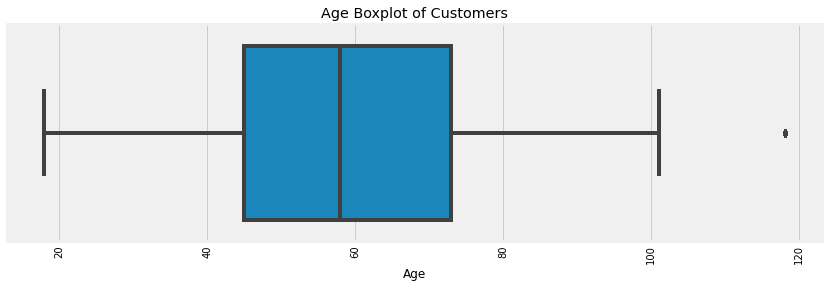

In [ ]:
# visualize the age distribution of the customers
plt.figure(figsize = (13, 4))
sns.boxplot(profile['age'])
plt.title('Age Boxplot of Customers')
plt.xlabel('Age')
plt.xticks(rotation = 90)
plt.show();

We can see above that the age = 118 value does not make sense there as it is clearly out of the normal distribution.

Text(0.5, 1.0, 'Gender Distribution')

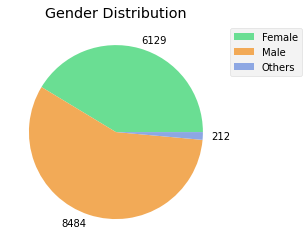

In [ ]:
#Gender Distribution
group_by_gender= profile.groupby(profile['gender'])['gender'].count()
labels= ['Female','Male', 'Others']
plt.pie( group_by_gender,labels= group_by_gender, colors= ['#6ade93', '#f2aa57', '#8da7e3'])
plt.legend(labels, bbox_to_anchor=(1,1))
plt.title('Gender Distribution')

Majority of the customers are male.

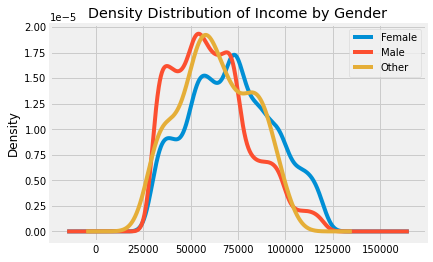

In [ ]:
# visualize the correlation of gender and income
gender_array = ["F", "M", "O"]
for g in gender_array:
    profile[profile.gender == g].income.plot(kind="kde")
plt.title("Density Distribution of Income by Gender")
plt.legend(("Female", "Male", "Other"));

Female customers have higher density in higher income range. 

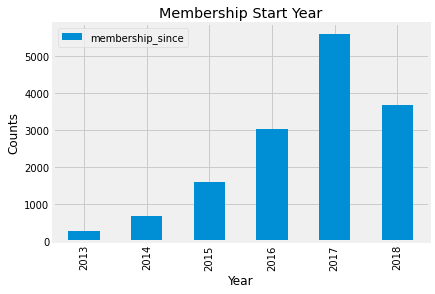

In [ ]:
# visualize the membership year
clean_profile[['membership_since']].groupby(clean_profile.membership_since).count().plot.bar(width=0.5);
plt.title('Membership Start Year');
plt.ylabel('Counts');
plt.xlabel('Year');

Text(0.5, 1.0, 'Offers Received by the Customers')

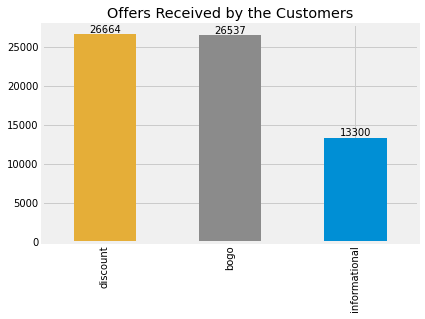

In [ ]:
# visualize the offers received by the customers
received = clean_transcript[clean_transcript['offer_received'] == 1].offer_type.value_counts()
received.plot(kind = 'bar', color=['C2', 'C4', 'C6'])
for i, typ in enumerate(received):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Offers Received by the Customers')

Text(0.5, 1.0, 'Offer Viewed by the Customers')

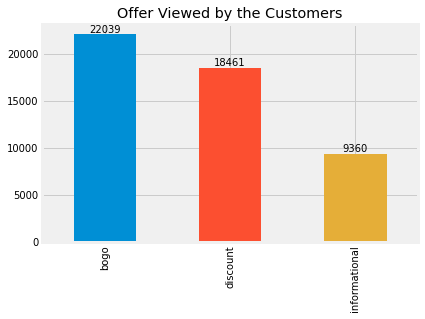

In [ ]:
# visualize the offers viewed by the custoers
viewed= clean_transcript[clean_transcript['offer_viewed']==1].offer_type.value_counts()
viewed.plot(kind='bar', color=['C0', 'C1', 'C2'])
for i, typ in enumerate(viewed):
    plt.text(i, typ, typ, ha = 'center', va = 'bottom');
plt.title('Offer Viewed by the Customers')

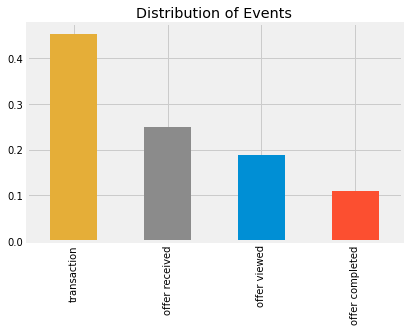

In [ ]:
# distribution of the events among the advertisement
transcript.event.value_counts(normalize=True).plot(kind="bar", color=['C2', 'C4', 'C6', 'C7'])
plt.title("Distribution of Events");

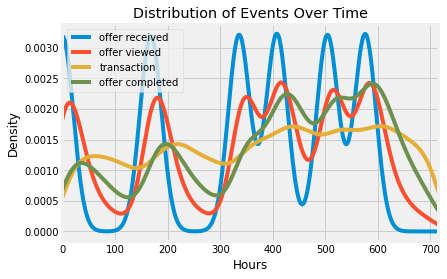

In [ ]:
# distribution of events over time
events = transcript.event.unique()
for event in events:
    transcript[transcript.event == event].time.plot(kind = 'kde')
plt.xlabel('Hours')
plt.legend(events)
plt.xlim(0, 715)
plt.title('Distribution of Events Over Time');